## Libraries importing

In [1]:
# Imorting basic libraries
import os
from datetime import datetime

# Importing basic ml libraries
import pandas as pd
import numpy as np 
import matplotlib as plt

# Importing dataset 
from keras.datasets import mnist

# Importing visualization tools
from matplotlib import pyplot

# Importing model 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# Importing hyperparameters optimization libraries
from hyperopt import fmin, tpe, hp

2023-08-09 15:37:44.424061: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 15:37:44.838235: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-09 15:37:44.839877: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 15:37:46.489691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Constants

In [2]:
EPOCHS = 50
BATCH_SIZE = 32 
MODEL_NAME = "best_model"
FORMAT = "keras"
PATH = "./models"  

## Loading training and test data

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
  
print(f"x_train set shape: {x_train.shape}")
print(f"y_train set shape: {y_train.shape}")
print(f"x_test set shape: {x_test.shape}")
print(f"y_test set shape: {y_test.shape}")

x_train set shape: (60000, 28, 28)
y_train set shape: (60000,)
x_test set shape: (10000, 28, 28)
y_test set shape: (10000,)


## Dataset visualization

Number 5


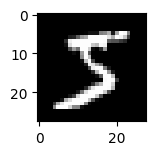

----------------------------------------------------------------------------------------------------
Number 0


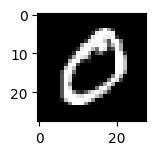

----------------------------------------------------------------------------------------------------
Number 4


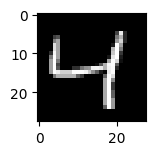

----------------------------------------------------------------------------------------------------


In [4]:
for i in range(3):  
    print(f"Number {y_train[i]}")
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    
    print(100*'-')

## Normalizing the pixel values to be in the range [0, 1]

In [5]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

## One-hot encoding the target labels

In [6]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Defining the function which build and compile the model

In [7]:
def build_model(parameters):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    
    for units in parameters["units"]:
        model.add(Dense(units, activation="relu"))

    model.add(Dense(10, activation="softmax"))

    optimizer = parameters["optimizer"]
    model.compile(optimizer=optimizer(learning_rate=parameters["learning_rate"]),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
                  
    return model

## Defining the objective function to minimize

We use negative accuracy since we want to maximize accuracy

In [8]:
best_accuracy = 0.0
best_model = None

def objective(parameters):
    model = build_model(parameters)
    history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.1, verbose=0)
    val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)
    
    global best_accuracy, best_model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model  # Save the best model

    return -val_accuracy

## Defining the hyperparameter search space

In [9]:
space = {
    "num_hidden_layers": hp.choice("num_hidden_layers", [1, 2, 3]),
    "units": hp.choice("units", [[64], [128], [256]]),
    "optimizer": hp.choice("optimizer", [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam]),
    "learning_rate": hp.uniform("learning_rate", 0.0001, 0.01)
}

## Performing hyperparameter optimization

Algorithm of choice is Tree-structured Parzen Estimators (TPE)

In [10]:
best_parameters = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

best_num_hidden_layers = [1, 2, 3][best_parameters["num_hidden_layers"]]
best_units = [[64], [128], [256]][best_parameters["units"]]
best_optimizer = [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam][best_parameters["optimizer"]]
best_learning_rate = best_parameters["learning_rate"]

print("Best Hyperparameters:")
print(f"Number of Hidden Layers: {best_num_hidden_layers}")
print(f"Units in Hidden Layers: {best_units}")
print(f"Optimizer: {best_optimizer.__name__}")
print(f"Learning Rate: {best_learning_rate}")

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2023-08-09 15:37:51.556203: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.
2023-08-09 15:38:31.267164: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


 10%|█         | 1/10 [00:40<06:08, 40.95s/trial, best loss: -0.9711999893188477]

2023-08-09 15:38:32.542656: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.
2023-08-09 15:38:59.447611: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


 20%|██        | 2/10 [01:08<04:26, 33.35s/trial, best loss: -0.9711999893188477]

2023-08-09 15:39:00.517000: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


100%|██████████| 10/10 [05:25<00:00, 32.57s/trial, best loss: -0.9749000072479248]
Best Hyperparameters:
Number of Hidden Layers: 2
Units in Hidden Layers: [128]
Optimizer: Adam
Learning Rate: 0.0013069455936135118


## Training the best model with more epochs

In [11]:
best_model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

Epoch 1/50
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0333 - accuracy: 0.9892 - val_loss: 0.0758 - val_accuracy: 0.9793
Epoch 2/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.0898 - val_accuracy: 0.9770
Epoch 3/50
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0220 - accuracy: 0.9927 - val_loss: 0.0822 - val_accuracy: 0.9797
Epoch 4/50
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0950 - val_accuracy: 0.9765
Epoch 5/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 0.0957 - val_accuracy: 0.9778
Epoch 6/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.1205 - val_accuracy: 0.9730
Epoch 7/50
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.0975 - val_accuracy:

## Evaluating the best model on the test set

In [12]:
loss, accuracy = best_model.evaluate(x_test, y_test)

print(f"Test accuracy with best hyperparameters: {accuracy * 100:.2f}%")

313/313 [==============================] - 1s 3ms/step - loss: 0.2072 - accuracy: 0.9788
Test accuracy with best hyperparameters: 97.88%


## Saving the best model

In [13]:
if not os.path.exists(PATH):
    os.makedirs(PATH)

current_datetime = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
best_model.save(f"{PATH}/{MODEL_NAME}_{current_datetime}.{FORMAT}")